<a href="https://colab.research.google.com/github/kushi9900/Reddy/blob/main/GAI_LAB_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype("float32") / 255.0
X_train = np.expand_dims(X_train, axis=-1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
LATENT_DIM = 100

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        layers.Dense(7 * 7 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="sigmoid")
    ])
    return model


In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model


In [ ]:
generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [ ]:
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES = 16
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Epoch 1, Batch 50 processed
Epoch 1, Batch 100 processed
Epoch 1, Batch 150 processed
Epoch 1, Batch 200 processed
Epoch 1, Batch 250 processed
Epoch 1, Batch 300 processed
Epoch 1, Batch 350 processed
Epoch 1, Batch 400 processed
Epoch 1, Batch 450 processed
Time for epoch 1 is 620.76 sec


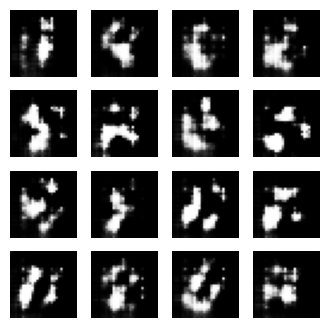

Epoch 2, Batch 50 processed
Epoch 2, Batch 100 processed
Epoch 2, Batch 150 processed
Epoch 2, Batch 200 processed
Epoch 2, Batch 250 processed
Epoch 2, Batch 300 processed
Epoch 2, Batch 350 processed
Epoch 2, Batch 400 processed
Epoch 2, Batch 450 processed
Time for epoch 2 is 618.48 sec


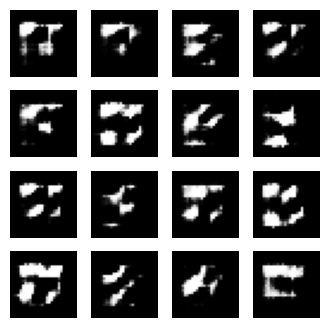

Epoch 3, Batch 50 processed
Epoch 3, Batch 100 processed
Epoch 3, Batch 150 processed
Epoch 3, Batch 200 processed
Epoch 3, Batch 250 processed
Epoch 3, Batch 300 processed
Epoch 3, Batch 350 processed
Epoch 3, Batch 400 processed
Epoch 3, Batch 450 processed
Time for epoch 3 is 616.77 sec


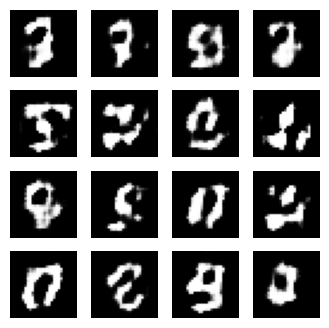

Epoch 4, Batch 50 processed
Epoch 4, Batch 100 processed
Epoch 4, Batch 150 processed
Epoch 4, Batch 200 processed
Epoch 4, Batch 250 processed
Epoch 4, Batch 300 processed
Epoch 4, Batch 350 processed
Epoch 4, Batch 400 processed
Epoch 4, Batch 450 processed
Time for epoch 4 is 619.88 sec


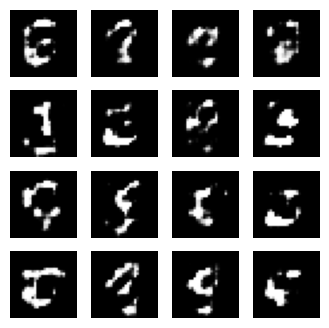

Epoch 5, Batch 50 processed
Epoch 5, Batch 100 processed
Epoch 5, Batch 150 processed
Epoch 5, Batch 200 processed
Epoch 5, Batch 250 processed
Epoch 5, Batch 300 processed
Epoch 5, Batch 350 processed
Epoch 5, Batch 400 processed
Epoch 5, Batch 450 processed
Time for epoch 5 is 618.22 sec


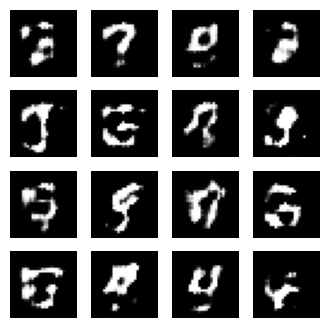

Epoch 6, Batch 50 processed
Epoch 6, Batch 100 processed
Epoch 6, Batch 150 processed
Epoch 6, Batch 200 processed
Epoch 6, Batch 250 processed
Epoch 6, Batch 300 processed
Epoch 6, Batch 350 processed


In [ ]:
def generate_and_save_images(model, epoch, test_input, save_images=True):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    if save_images:
        plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()
    plt.close(fig)

def train(dataset, epochs, save_images=True):
    for epoch in range(epochs):
        start = time.time()
        batch_count = 0
        for image_batch in dataset:
            train_step(image_batch)
            batch_count += 1
            if batch_count % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_count} processed")
        print(f'Time for epoch {epoch+1} is {time.time() - start:.2f} sec')
        generate_and_save_images(generator, epoch+1, seed, save_images=save_images)

# To speed up training, you can set save_images=False to skip saving and showing images every epoch
train(dataset, EPOCHS, save_images=False)